       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)     class_0     class_1     class_2  
count        150.000000  150.000000  150.000000  150.000000  
mean           1.199333    0.333333    0.333333    0.333333  
std            0.762238    0.472984    0.472984    0.472984  
min            0.100000    0.000000    0.000000    0.000000  
25%            0.300000    0.000000    0.000000    0.000000  
50%            1.300000    0.000000    0.0

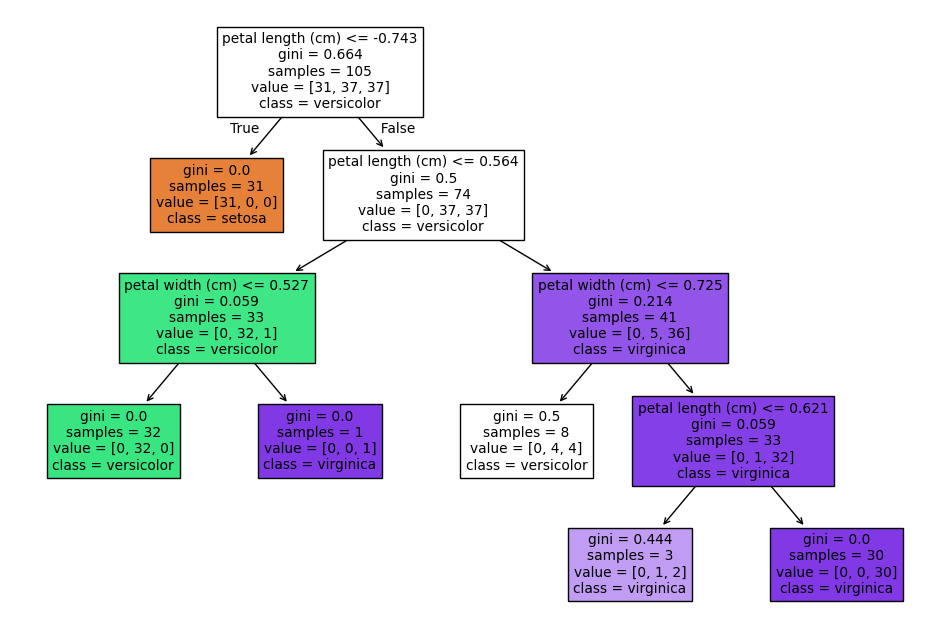

Test Accuracy: 1.0000


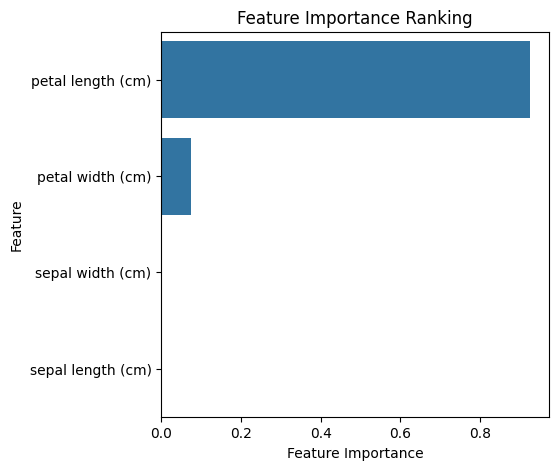

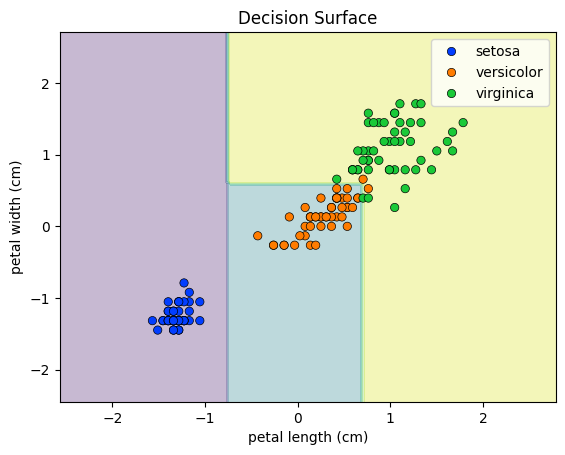

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
iris = load_iris()
X = iris.data
y = iris.target

# One-hot encode the target variable
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Compute summary statistics
df = pd.DataFrame(np.hstack((X, y_encoded)), columns=iris.feature_names + ["class_0", "class_1", "class_2"])
summary_stats = df.describe()
print(summary_stats)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Set up hyperparameter space
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20]
}

# Initiate DecisionTreeClassifier and perform GridSearchCV
clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Report cross-validation results
cv_results = pd.DataFrame(grid_search.cv_results_)
print(cv_results[['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features', 'param_max_leaf_nodes', 'mean_test_score']])

# Best model selected
best_model = grid_search.best_estimator_
print(f"Best Model: {grid_search.best_params_}")

# Plot final model tree structure
plt.figure(figsize=(12, 8))
plot_tree(best_model, feature_names=iris.feature_names, class_names=iris.target_names, filled=True)
plt.show()

# Evaluate model on test dataset
test_accuracy = best_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Feature importance bar chart
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(7, 5))
sns.barplot(x=importances[indices], y=np.array(iris.feature_names)[indices])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Ranking")
plt.show()

# Decision surface for two most important features
def plot_decision_boundary(model, X, y, feature_names):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=iris.target_names[y], palette='bright', edgecolor='k')
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title("Decision Surface")
    plt.show()

# Select top 2 features
top_features = indices[:2]
X_top2 = X_scaled[:, top_features]

# Train model on top 2 features
best_model.fit(X_top2, y)
plot_decision_boundary(best_model, X_top2, y, np.array(iris.feature_names)[top_features])
